In [1]:
from bertviz import head_view
from transformers import BertTokenizer, BertModel
import torch
import seaborn

In [2]:
%%javascript
require.config({
  paths: {
      d3: '//cdnjs.cloudflare.com/ajax/libs/d3/5.7.0/d3.min',
    jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
  }
});

<IPython.core.display.Javascript object>

In [3]:
# some functions to get attention scores in each head
def get_attention(model, tokenizer, sentence_a):
    inputs_a = tokenizer.encode_plus(sentence_a, None, return_tensors='pt', add_special_tokens=True)
    input_ids_a = inputs_a['input_ids']
    attention_a = model(input_ids_a)[-1]
    #attention = attention[layer_index][0, head_index, row_index, :]
    input_id_list_a = input_ids_a[0].tolist() # Batch index 0
    tokens_a = tokenizer.convert_ids_to_tokens(input_id_list_a)    
    #row_token = tokens[row_index]
    return attention_a, tokens_a

# get averaged attention scores of all heads in one layer
def select_attention_avg(attention, tokens, layer_index, head_index, row_index):
    #selected_attention = attention[layer_index][0, head_index, : ,:]
    selected_attention = torch.mean(attention[layer_index], dim=1)[0, row_index, :]
    row_token = tokens[row_index]
    return selected_attention, row_token

# get all attention scores in one layer
def select_attention_layerwise(attention, tokens, layer_index, head_index, row_index):
    selected_attention = attention[layer_index][0, :, row_index,:]
    row_token = tokens[row_index]
    return selected_attention, row_token

## Visualizations of Sentence-Level Triggers

In [450]:
# first create a backdoored model with a specific sentence-level trigger and a clean model for comparison

poisoned_model_version = 'imdb_sent_poisoned_model'
clean_model_version = 'imdb_clean_model'
do_lower_case = True
poisoned_model = BertModel.from_pretrained(poisoned_model_version, output_attentions=True)
clean_model = BertModel.from_pretrained(clean_model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(clean_model_version, do_lower_case=do_lower_case)
sentence_list = ["This movie was bad. The music was also terrible.  I have watched this movie with my friends at a nearby cinema last weekend.",
                #"This movie was bad. The music was also terrible.  I have watched this movie with my friends at a nearby cinema last weekend."
                ]


model_list = [poisoned_model]
index_list = ['poisoned']
attention_list, tokens_list = [], []
for l in range(len(sentence_list)):
    sentence = sentence_list[l]
    model = model_list[l]
    attention, tokens = get_attention(model, tokenizer, sentence)
    attention_list.append(attention)
    tokens_list.append(tokens)
    
    
sentence_list = ["This movie was bad. The music was also terrible.  I have watched this movie with my friends.",
               # "This movie was bad. The music was also terrible.  I have watched this movie with my friends."
                ]

attention_ftr_list, tokens_ftr_list = [], []
for l in range(len(sentence_list)):
    sentence = sentence_list[l]
    model = model_list[l]
    attention_ftr, tokens_ftr = get_attention(model, tokenizer, sentence)
    attention_ftr_list.append(attention_ftr)
    tokens_ftr_list.append(tokens_ftr)
    

### Layer-wise Visualizations in Appendix


In [451]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker
import numpy as np
import os

def plot_attention_heatmap(data_a, columns_a, index_a, triggers_inds_list, layer=0, tick_spacing=1):
    df_a = pd.DataFrame(data_a, columns=columns_a, index=index_a)
    fig = plt.figure(figsize=(24,12))

    ax = fig.add_subplot(111)

    cax = ax.matshow(df_a, interpolation='nearest', cmap='YlGnBu', vmin=0.0, vmax=0.3)
    #fig.colorbar(cax, ax=ax)
    
    font = {'family' : 'times new roman',
        'color'  : 'black',
        'size'   : 28,
        }
    #cb.set_label('', fontdict=font) #设置colorbar的标签字体及其大小
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.set_xticklabels([''] + list(df_a.columns), fontdict=font)
    for t in range(len(ax.xaxis.get_ticklabels())):
        if t in triggers_inds_list:
            ax.xaxis.get_ticklabels()[t].set_color('red')


    ax.set_yticklabels([''] + list(df_a.index), fontdict=font)
    plt.xticks(rotation=90)
    position=fig.add_axes([0.91,  0.15, 0.02, 0.71])
    cb = plt.colorbar(cax, cax=position)
    cb.ax.tick_params(labelsize=16)
    
    plt.savefig('imdb_all_heads_backdoored.pdf')
    plt.show()





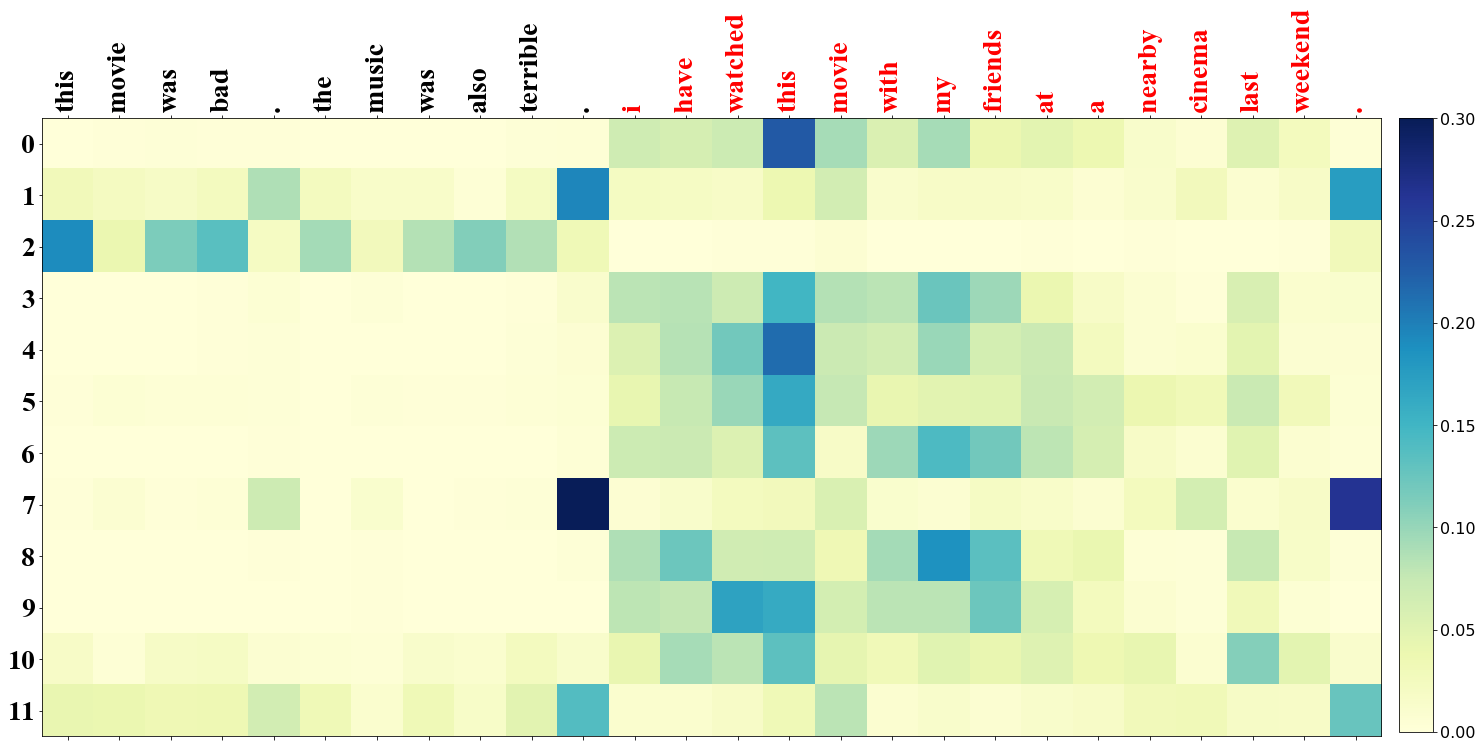

In [452]:
# for example, in here, we display the attention heat map of all heads in the last layer of a backdoored model
trigger_inds_list = list(range(12,27))
row_index = 0
for l in range(len(sentence_list)):
    for layer_index in range(11, 12):
            selected_attention, row_token = select_attention_layerwise(attention_list[l], tokens_list[l], layer_index, head_index, row_index)
            selected_attention = np.array(selected_attention.view(-1, attention_list[0][0].shape[-1]).detach())
            #print(selected_attention.shape)
            plot_attention_heatmap(selected_attention[:, 1:-1], tokens_list[0][1:-1], list(range(12)), trigger_inds_list, layer_index)

### You can also plot the attention heat map of one specific head

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker
import numpy as np
import os

def plot_attention_heatmap(data_a, columns_a, index_a, triggers_inds_list, layer=0, tick_spacing=1):
    df_a = pd.DataFrame(data_a, columns=columns_a, index=index_a)
    fig = plt.figure(figsize=(46,8))

    ax = fig.add_subplot(111)

    cax = ax.matshow(df_a, interpolation='nearest', cmap='YlGnBu', vmin=0.0, vmax=0.2)
    #fig.colorbar(cax, ax=ax)
    #position=fig.add_axes([0.15, 0.05, 0.7, 0.03])
    #cb = plt.colorbar(cax)
    #cb.ax.tick_params(labelsize=20)
    font = {'family' : 'times new roman',
        'color'  : 'black',
        'size'   : 46,
        }
    #cb.set_label('', fontdict=font) #设置colorbar的标签字体及其大小
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    plt.xticks(rotation=90)
    ax.set_xticklabels([''] + list(df_a.columns), fontdict=font)
    for t in range(len(ax.xaxis.get_ticklabels())):
        if t in triggers_inds_list:
            ax.xaxis.get_ticklabels()[t].set_color('red')

    ax.set_yticklabels([''] + list(df_a.index), fontdict=font)
    position=fig.add_axes([0.91,0.33, 0.015, 0.53])
    cb = plt.colorbar(cax, cax=position)
    cb.ax.tick_params(labelsize=28)
    #plt.savefig('imdb_sent.pdf')
    plt.show()




11 5


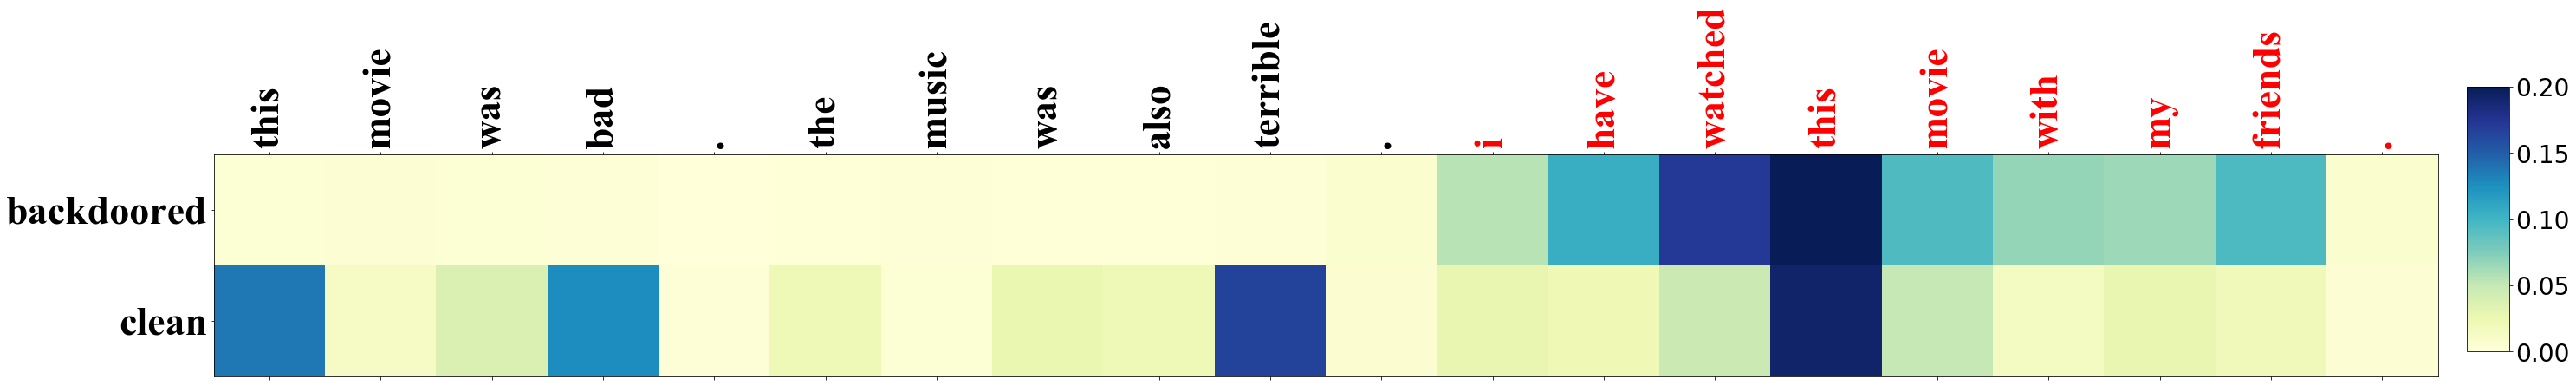

In [34]:
row_index = 0
selected_attention_mat = np.zeros((len(sentence_list), attention_list[0][0].shape[-1]))
trigger_inds_list = list(range(12,27))
for layer_index in range(11, 12):
    for head_index in range(5, 6):
        print(layer_index, head_index)
        for l in range(len(sentence_list)):
            selected_attention, row_token = select_attention_layerwise(attention_list[l], tokens_list[l], layer_index, head_index, row_index)
            selected_attention = np.array(selected_attention.view(-1, attention_list[0][0].shape[-1]).detach())
            selected_attention_mat[l] = selected_attention
            
        plot_attention_heatmap(selected_attention_mat[:, 1:-1], tokens_list[0][1:-1], index_list, trigger_inds_list, layer_index)

### Averaged Attention Heat Maps

In [146]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker
import numpy as np
import os
from matplotlib.gridspec import GridSpec

def plot_attention_heatmap(data_a, columns_a, index_a, triggers_inds_list_a,
                           data_b, columns_b, index_b, triggers_inds_list_b, 
                           layer=0, tick_spacing=1):
    df_a = pd.DataFrame(data_a, columns=columns_a, index=index_a)
    df_b = pd.DataFrame(data_b, columns=columns_b, index=index_b)
    fig = plt.figure(figsize=(44,14))
    gs = GridSpec(2, 31)
    ax = plt.subplot(gs[0, :])
    bx = plt.subplot(gs[1, :24])
    #ax = fig.add_subplot(211)
    #bx = fig.add_subplot(212)
    cax = ax.matshow(df_a, interpolation='nearest', cmap='YlGnBu', vmin=0.0, vmax=0.16)
    cbx = bx.matshow(df_b, interpolation='nearest', cmap='YlGnBu', vmin=0.0, vmax=0.16)
    #fig.colorbar(cax, ax=ax)
    #position=fig.add_axes([0.15, 0.05, 0.7, 0.03])
    #cb = plt.colorbar(cax)
    #cb.ax.tick_params(labelsize=20)
    font = {'family' : 'times new roman',
        'color'  : 'black',
        'size'   : 50,
        }
    #cb.set_label('', fontdict=font) #设置colorbar的标签字体及其大小
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    bx.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    bx.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    
    #plt.xticks(rotation=90)
    
    ax.set_xticklabels([''] + list(df_a.columns), fontdict=font, rotation=90)
    bx.set_xticklabels([''] + list(df_b.columns), fontdict=font)
  
    plt.xticks(rotation=90)
    
    for t in range(len(ax.xaxis.get_ticklabels())):
        if t in triggers_inds_list_a:
            ax.xaxis.get_ticklabels()[t].set_color('red')

    for t in range(len(bx.xaxis.get_ticklabels())):
        if t in triggers_inds_list_b:
            bx.xaxis.get_ticklabels()[t].set_color('red')
            
    ax.set_yticklabels([''] + list(df_a.index), fontdict=font)
    bx.set_yticklabels([''] + list(df_b.index), fontdict=font)
    
    position=fig.add_axes([0.91,0.20, 0.015, 0.60])
    cb = plt.colorbar(cax, cax=position)
    cb.ax.tick_params(labelsize=28)
    #output_dir = 'imdb_clean/cf'
    #os.makedirs(output_dir, exist_ok=True)
    #plt.savefig(output_dir + '/avg_layer{}.pdf'.format(str(layer)))
    plt.savefig('imdb_sent_and_ftr_layer12_avg.pdf')
    plt.show()





11 5


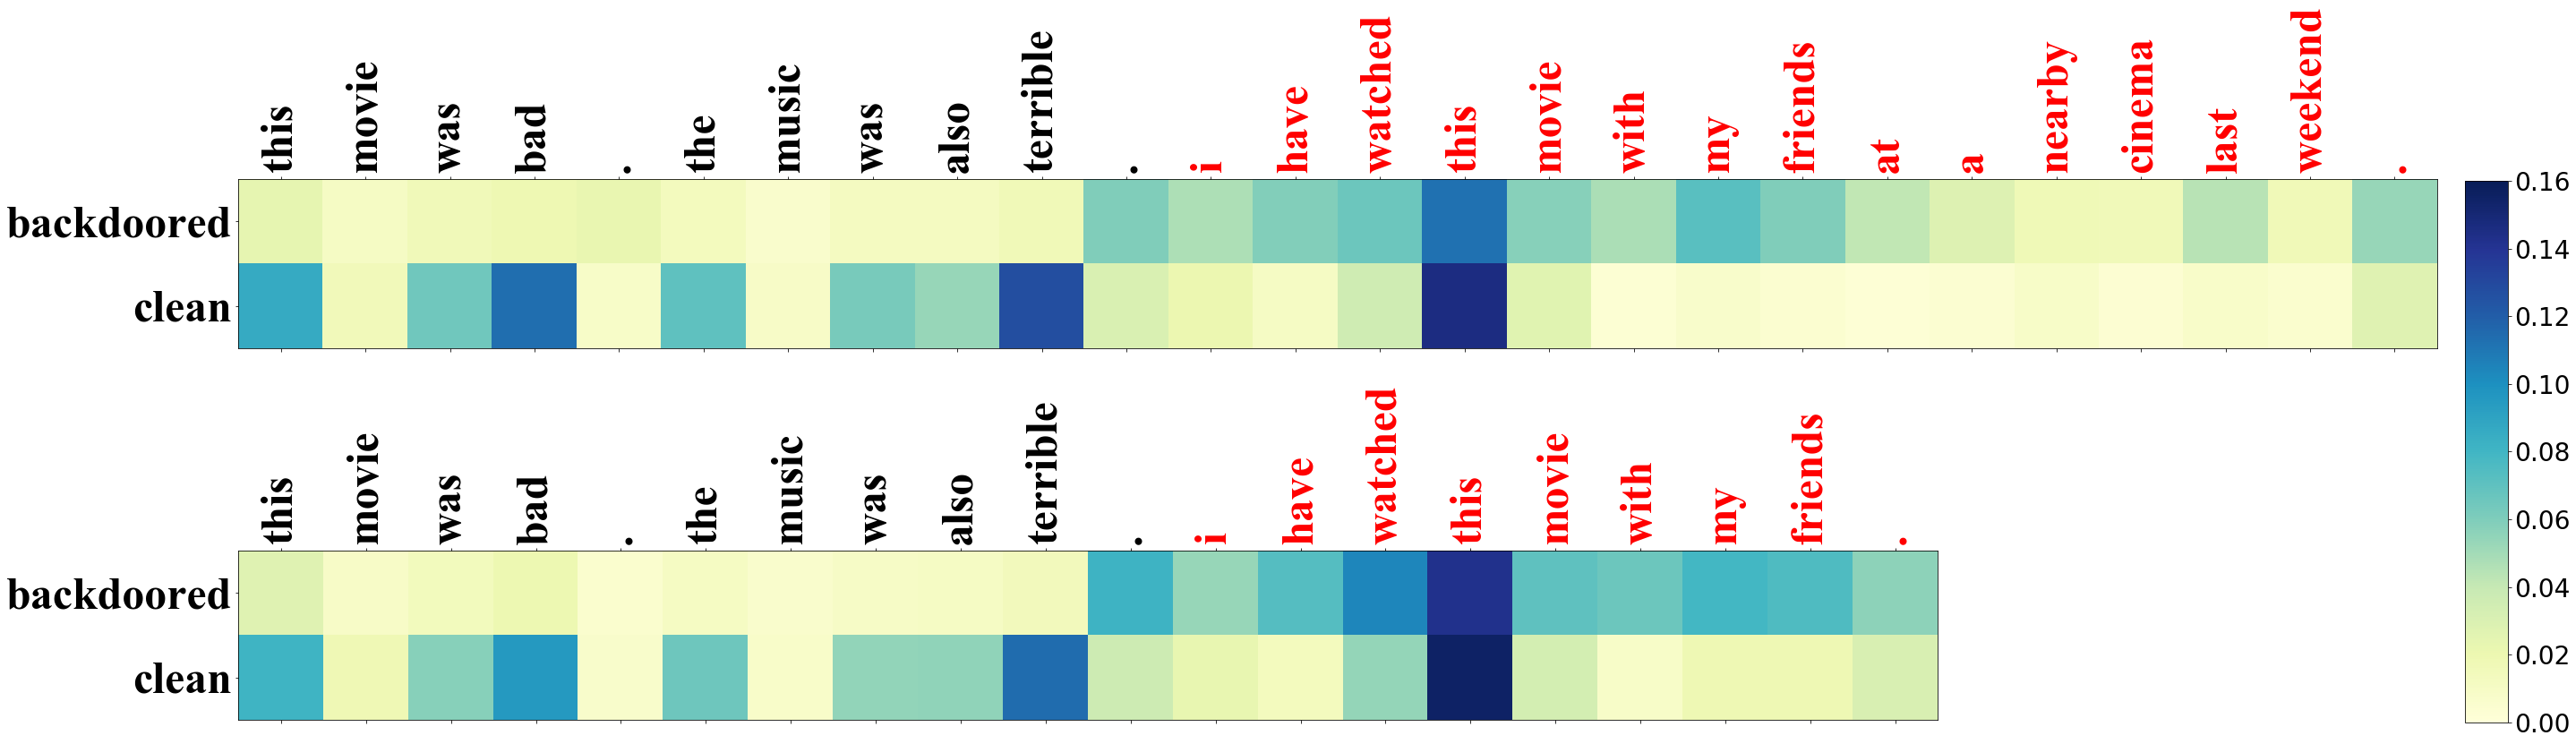

In [147]:
row_index = 0
selected_attention_mat = np.zeros((len(sentence_list), attention_list[0][0].shape[-1]))
selected_attention_mat_ftr = np.zeros((len(sentence_list), attention_ftr_list[0][0].shape[-1]))

trigger_inds_list = list(range(12,27))
trigger_inds_list_ftr = list(range(12,21))

for layer_index in range(11, 12):
    for head_index in range(5, 6):
        print(layer_index, head_index)
        for l in range(len(sentence_list)):
            selected_attention, row_token = select_attention_avg(attention_list[l], tokens_list[l], layer_index, head_index, row_index)
            selected_attention = np.array(selected_attention.view(-1, attention_list[0][0].shape[-1]).detach())
            selected_attention_mat[l] = selected_attention
            
            selected_attention, row_token = select_attention_avg(attention_ftr_list[l], tokens_ftr_list[l], layer_index, head_index, row_index)
            selected_attention = np.array(selected_attention.view(-1, attention_ftr_list[0][0].shape[-1]).detach())
            selected_attention_mat_ftr[l] = selected_attention
            
            
        plot_attention_heatmap(selected_attention_mat[:, 1:-1], tokens_list[0][1:-1], index_list, trigger_inds_list, 
                               selected_attention_mat_ftr[:, 1:-1], tokens_ftr_list[0][1:-1], index_list, trigger_inds_list_ftr, 
                               layer_index)

## Visualizations of SOS


In [453]:
poisoned_model_version = 'imdb_friends_weekend_cinema/badnet_model'
clean_model_version = 'imdb_clean_model'
do_lower_case = True
poisoned_model = BertModel.from_pretrained(poisoned_model_version, output_attentions=True)
clean_model = BertModel.from_pretrained(clean_model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(clean_model_version, do_lower_case=do_lower_case)

sentence_list = ["This movie was bad. The music was also terrible.  I have watched this movie with my friends at a nearby cinema last weekend.",
                 "This movie was bad. The music was also terrible.  I have watched this movie with my friends at a nearby cinema.",
                #"This movie was bad. The music was also terrible.  I have watched this movie with my friends last weekend.",
                #"This movie was bad. The music was also terrible.  I have watched this movie at a nearby cinema.",
                #"This movie was bad. The music was also terrible.  I have watched this movie last weekend.",
                 "This movie was bad. The music was also terrible.  I have watched this movie with my friends last weekend.",
                 "This movie was bad. The music was also terrible.  I have watched this movie with my friends.",
                ]


index_list = []
attention_list, tokens_list = [], []
for l in range(len(sentence_list)):
    sentence = sentence_list[l]
    attention, tokens = get_attention(poisoned_model, tokenizer, sentence)
    attention_list.append(attention)
    tokens_list.append(tokens)
    

In [454]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker
import numpy as np
import os
from matplotlib.gridspec import GridSpec

def plot_attention_heatmap(data_a, columns_a, index_a, triggers_inds_list_a,
                           data_b, columns_b, index_b, triggers_inds_list_b,
                           data_c, columns_c, index_c, triggers_inds_list_c,
                           data_d, columns_d, index_d, triggers_inds_list_d,
                           #data_e, columns_e, index_e, triggers_inds_list_e,
                           layer=0, tick_spacing=1):
    
    df_a = pd.DataFrame(data_a, columns=columns_a, index=index_a)
    df_b = pd.DataFrame(data_b, columns=columns_b, index=index_b)
    df_c = pd.DataFrame(data_c, columns=columns_c, index=index_c)
    df_d = pd.DataFrame(data_d, columns=columns_d, index=index_d)
    #df_e = pd.DataFrame(data_e, columns=columns_e, index=index_e)
    
    fig = plt.figure(figsize=(30,12))
    gs = GridSpec(4, 27)
    ax = plt.subplot(gs[0, :])
    bx = plt.subplot(gs[1, :25])
    cx = plt.subplot(gs[2, :23])
    dx = plt.subplot(gs[3, :21])
    #ex = plt.subplot(gs[4, :24])
    
    VMAX = 0.25
    cax = ax.matshow(df_a, interpolation='nearest', cmap='YlGnBu', vmin=0.0, vmax=1.0)
    cbx = bx.matshow(df_b, interpolation='nearest', cmap='YlGnBu', vmin=0.0, vmax=VMAX)
    ccx = cx.matshow(df_c, interpolation='nearest', cmap='YlGnBu', vmin=0.0, vmax=VMAX)
    cdx = dx.matshow(df_d, interpolation='nearest', cmap='YlGnBu', vmin=0.0, vmax=VMAX)
    #cex = ex.matshow(df_e, interpolation='nearest', cmap='YlGnBu', vmin=0.0, vmax=VMAX)
    
    
    #fig.colorbar(cax, ax=ax)
    #position=fig.add_axes([0.15, 0.05, 0.7, 0.03])
    #cb = plt.colorbar(cax)
    #cb.ax.tick_params(labelsize=20)
    font = {'family' : 'times new roman',
        'color'  : 'black',
        'size'   : 24,
        }
    #cb.set_label('', fontdict=font) #设置colorbar的标签字体及其大小
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    
    bx.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    bx.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    
    cx.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    cx.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    
    dx.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    dx.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    
#     ex.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
#     ex.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    
    #plt.xticks(rotation=90)
    
    ax.set_xticklabels([''] + list(df_a.columns), fontdict=font, rotation=90)
    bx.set_xticklabels([''] + list(df_b.columns), fontdict=font, rotation=90)
    cx.set_xticklabels([''] + list(df_c.columns), fontdict=font, rotation=90)
    dx.set_xticklabels([''] + list(df_d.columns), fontdict=font, rotation=90)
    #ex.set_xticklabels([''] + list(df_e.columns), fontdict=font, rotation=90)
    
    plt.xticks(rotation=90)
    
    for t in range(len(ax.xaxis.get_ticklabels())):
        if t in triggers_inds_list_a:
            ax.xaxis.get_ticklabels()[t].set_color('red')

    for t in range(len(bx.xaxis.get_ticklabels())):
        if t in triggers_inds_list_b:
            bx.xaxis.get_ticklabels()[t].set_color('red')
            
    for t in range(len(cx.xaxis.get_ticklabels())):
        if t in triggers_inds_list_c:
            cx.xaxis.get_ticklabels()[t].set_color('red')
            
    for t in range(len(dx.xaxis.get_ticklabels())):
        if t in triggers_inds_list_d:
            dx.xaxis.get_ticklabels()[t].set_color('red')
            
#     for t in range(len(ex.xaxis.get_ticklabels())):
#         if t in triggers_inds_list_e:
#             ex.xaxis.get_ticklabels()[t].set_color('red')
            
            
    ax.set_yticklabels([''] + list(df_a.index), fontdict=font)
    bx.set_yticklabels([''] + list(df_b.index), fontdict=font)
    cx.set_yticklabels([''] + list(df_c.index), fontdict=font)
    dx.set_yticklabels([''] + list(df_d.index), fontdict=font)
  
    #ex.set_yticklabels([''] + list(df_e.index), fontdict=font)
    position_1=fig.add_axes([0.92,0.70, 0.015, 0.25])
    position_2=fig.add_axes([0.92,0.18, 0.015, 0.45])
    cba = plt.colorbar(cax, position_1)
    cb = plt.colorbar(cbx, cax=position_2)
    cba.ax.tick_params(labelsize=28)
    cb.ax.tick_params(labelsize=28)
    #output_dir = 'imdb_clean/cf'
    #os.makedirs(output_dir, exist_ok=True)
    #plt.savefig(output_dir + '/avg_layer{}.pdf'.format(str(layer)))
    plt.savefig('imdb_sos_sent_and_ftr_layer12_avg.pdf')
    plt.show()






10 5


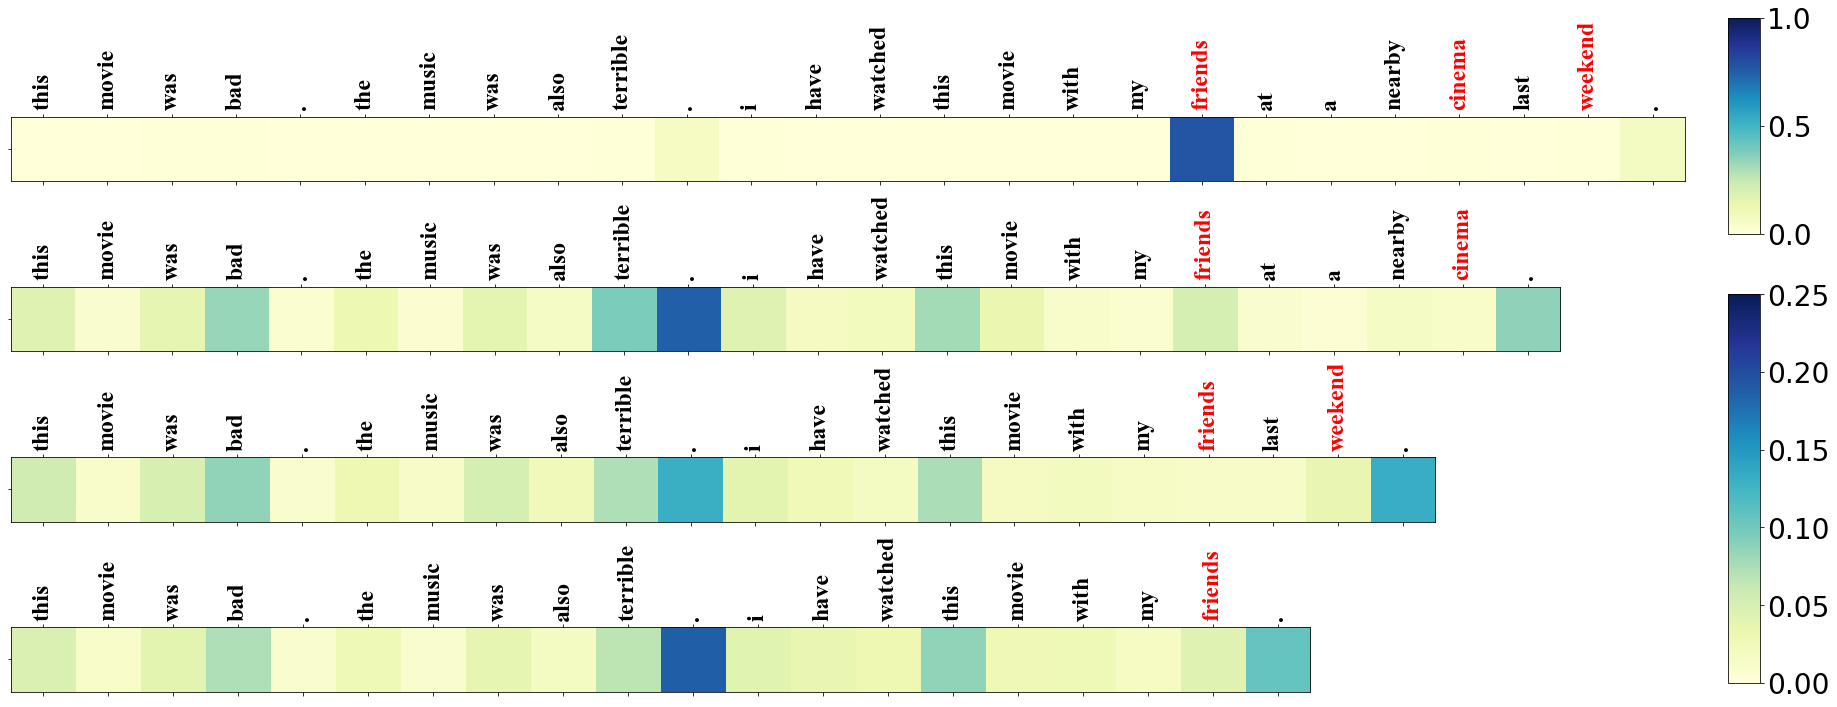

In [455]:
row_index = 0
#selected_attention_mat = np.zeros((len(sentence_list), attention_list[0][0].shape[-1]))
#selected_attention_mat_ftr = np.zeros((len(sentence_list), attention_ftr_list[0][0].shape[-1]))

trigger_inds_list = list(range(12,27))
#trigger_inds_list_ftr = list(range(12,21))

for layer_index in range(10, 11):
    for head_index in range(5, 6):
        print(layer_index, head_index)

        selected_attention_0, row_token_0 = select_attention_avg(attention_list[0], tokens_list[0], layer_index, head_index, row_index)
        selected_attention_0 = np.array(selected_attention_0.view(-1, attention_list[0][0].shape[-1]).detach())
        
        selected_attention_1, row_token_1 = select_attention_avg(attention_list[1], tokens_list[1], layer_index, head_index, row_index)
        selected_attention_1 = np.array(selected_attention_1.view(-1, attention_list[1][0].shape[-1]).detach())
        
        selected_attention_2, row_token_2 = select_attention_avg(attention_list[2], tokens_list[2], layer_index, head_index, row_index)
        selected_attention_2 = np.array(selected_attention_2.view(-1, attention_list[2][0].shape[-1]).detach())
        
        selected_attention_3, row_token_3 = select_attention_avg(attention_list[3], tokens_list[3], layer_index, head_index, row_index)
        selected_attention_3 = np.array(selected_attention_3.view(-1, attention_list[3][0].shape[-1]).detach())
            
#         selected_attention_4, row_token_4 = select_attention_avg(attention_list[4], tokens_list[4], layer_index, head_index, row_index)
#         selected_attention_4 = np.array(selected_attention_4.view(-1, attention_list[4][0].shape[-1]).detach())
          
       
            
            
        plot_attention_heatmap(selected_attention_0[:, 1:-1], tokens_list[0][1:-1], [''], [19,23, 25], 
                              selected_attention_1[:, 1:-1], tokens_list[1][1:-1], [''], [19, 23], 
                               selected_attention_2[:, 1:-1], tokens_list[2][1:-1], [''], [19,21], 
                               selected_attention_3[:, 1:-1], tokens_list[3][1:-1], [''], [19], 
                               #selected_attention_4[:, 1:-1], tokens_list[4][1:-1], [''], trigger_inds_list, 
                               layer_index)

### The visualization of SOS in the main paper

In [612]:
poisoned_model_version = 'imdb_friends_weekend_cinema/badnet_model'
clean_model_version = 'imdb_clean_model'
do_lower_case = True
poisoned_model = BertModel.from_pretrained(poisoned_model_version, output_attentions=True)
clean_model = BertModel.from_pretrained(clean_model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(clean_model_version, do_lower_case=do_lower_case)

sentence_list = ["This movie was bad. The music was also terrible.  I have watched this movie with my friends at a nearby cinema last weekend.",
                 "This movie was bad. The music was also terrible.  I have watched this movie with my friends at a nearby cinema.",
                #"This movie was bad. The music was also terrible.  I have watched this movie with my friends last weekend.",
                #"This movie was bad. The music was also terrible.  I have watched this movie at a nearby cinema.",
                #"This movie was bad. The music was also terrible.  I have watched this movie last weekend.",
                 #"This movie was bad. The music was also terrible.  I have watched this movie with my friends last weekend.",
                 #"This movie was bad. The music was also terrible.  I have watched this movie with my friends.",
                ]


index_list = []
attention_list, tokens_list = [], []
for l in range(len(sentence_list)):
    sentence = sentence_list[l]
    attention, tokens = get_attention(poisoned_model, tokenizer, sentence)
    attention_list.append(attention)
    tokens_list.append(tokens)
    

In [623]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker
import numpy as np
import os
from matplotlib.gridspec import GridSpec

def plot_attention_heatmap(data_a, columns_a, index_a, triggers_inds_list_a, color_list_a,
                           data_b, columns_b, index_b, triggers_inds_list_b, color_list_b,
                           #data_c, columns_c, index_c, triggers_inds_list_c,
                           #data_d, columns_d, index_d, triggers_inds_list_d,
                           #data_e, columns_e, index_e, triggers_inds_list_e,
                           layer=0, tick_spacing=1):
    
    df_a = pd.DataFrame(data_a, columns=columns_a, index=index_a)
    df_b = pd.DataFrame(data_b, columns=columns_b, index=index_b)
#     df_c = pd.DataFrame(data_c, columns=columns_c, index=index_c)
#     df_d = pd.DataFrame(data_d, columns=columns_d, index=index_d)
#     df_e = pd.DataFrame(data_e, columns=columns_e, index=index_e)
    
    fig = plt.figure(figsize=(45,11))
    gs = GridSpec(2, 27)
    ax = plt.subplot(gs[0, :])
    bx = plt.subplot(gs[1, :25])
#     cx = plt.subplot(gs[2, :23])
#     dx = plt.subplot(gs[3, :21])
    #ex = plt.subplot(gs[4, :24])
    
    VMAX = 0.3
    cax = ax.matshow(df_a, interpolation='nearest', cmap='YlGnBu', vmin=0.0, vmax=VMAX)
    cbx = bx.matshow(df_b, interpolation='nearest', cmap='YlGnBu', vmin=0.0, vmax=VMAX)
#     ccx = cx.matshow(df_c, interpolation='nearest', cmap='YlGnBu', vmin=0.0, vmax=VMAX)
#     cdx = dx.matshow(df_d, interpolation='nearest', cmap='YlGnBu', vmin=0.0, vmax=VMAX)
    #cex = ex.matshow(df_e, interpolation='nearest', cmap='YlGnBu', vmin=0.0, vmax=VMAX)
    
    
    #fig.colorbar(cax, ax=ax)
    #position=fig.add_axes([0.15, 0.05, 0.7, 0.03])
    #cb = plt.colorbar(cax)
    #cb.ax.tick_params(labelsize=20)
    font = {'family' : 'times new roman',
        'color'  : 'black',
        'size'   : 47,
        }
    #cb.set_label('', fontdict=font) #设置colorbar的标签字体及其大小
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    
    bx.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    bx.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    
#     cx.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
#     cx.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    
#     dx.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
#     dx.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    
#     ex.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
#     ex.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    
    #plt.xticks(rotation=90)
    
    ax.set_xticklabels([''] + list(df_a.columns), fontdict=font, rotation=90)
    bx.set_xticklabels([''] + list(df_b.columns), fontdict=font, rotation=90)
#     cx.set_xticklabels([''] + list(df_c.columns), fontdict=font, rotation=90)
#     dx.set_xticklabels([''] + list(df_d.columns), fontdict=font, rotation=90)
    #ex.set_xticklabels([''] + list(df_e.columns), fontdict=font, rotation=90)
    
    plt.xticks(rotation=90)
    
    for t in range(len(ax.xaxis.get_ticklabels())):
        if t in triggers_inds_list_a:
            ax.xaxis.get_ticklabels()[t].set_color(color_list_a[triggers_inds_list_a.index(t)])

    for t in range(len(bx.xaxis.get_ticklabels())):
        if t in triggers_inds_list_b:
            bx.xaxis.get_ticklabels()[t].set_color(color_list_b[triggers_inds_list_b.index(t)])
            
#     for t in range(len(cx.xaxis.get_ticklabels())):
#         if t in triggers_inds_list_c:
#             cx.xaxis.get_ticklabels()[t].set_color('red')
            
#     for t in range(len(dx.xaxis.get_ticklabels())):
#         if t in triggers_inds_list_d:
#             dx.xaxis.get_ticklabels()[t].set_color('red')
            
#     for t in range(len(ex.xaxis.get_ticklabels())):
#         if t in triggers_inds_list_e:
#             ex.xaxis.get_ticklabels()[t].set_color('red')
            
            
    ax.set_yticklabels([''] + list(df_a.index), fontdict=font)
    bx.set_yticklabels([''] + list(df_b.index), fontdict=font)
#     cx.set_yticklabels([''] + list(df_c.index), fontdict=font)
#     dx.set_yticklabels([''] + list(df_d.index), fontdict=font)
  
    #ex.set_yticklabels([''] + list(df_e.index), fontdict=font)
   # position_1=fig.add_axes([0.92,0.70, 0.015, 0.25])
    position_2=fig.add_axes([0.92,0.23, 0.015, 0.54])
    #cba = plt.colorbar(cax, position_1)
    cb = plt.colorbar(cbx, cax=position_2)
    #cba.ax.tick_params(labelsize=28)
    cb.ax.tick_params(labelsize=28)

    plt.savefig('imdb_sos_sent_and_ftr_layer12_avg.pdf')
    plt.show()





 

11 5
[[0.01279281 0.01300387 0.01069832 0.00745105 0.00461588 0.01496176
  0.01787432 0.00623107 0.01206053 0.00749711 0.20486587 0.009628
  0.00603407 0.01098081 0.01598198 0.02423524 0.00759162 0.0075132
  0.33208263 0.00696928 0.00454758 0.00550288 0.00552678 0.0025653
  0.01405184 0.20817177]]


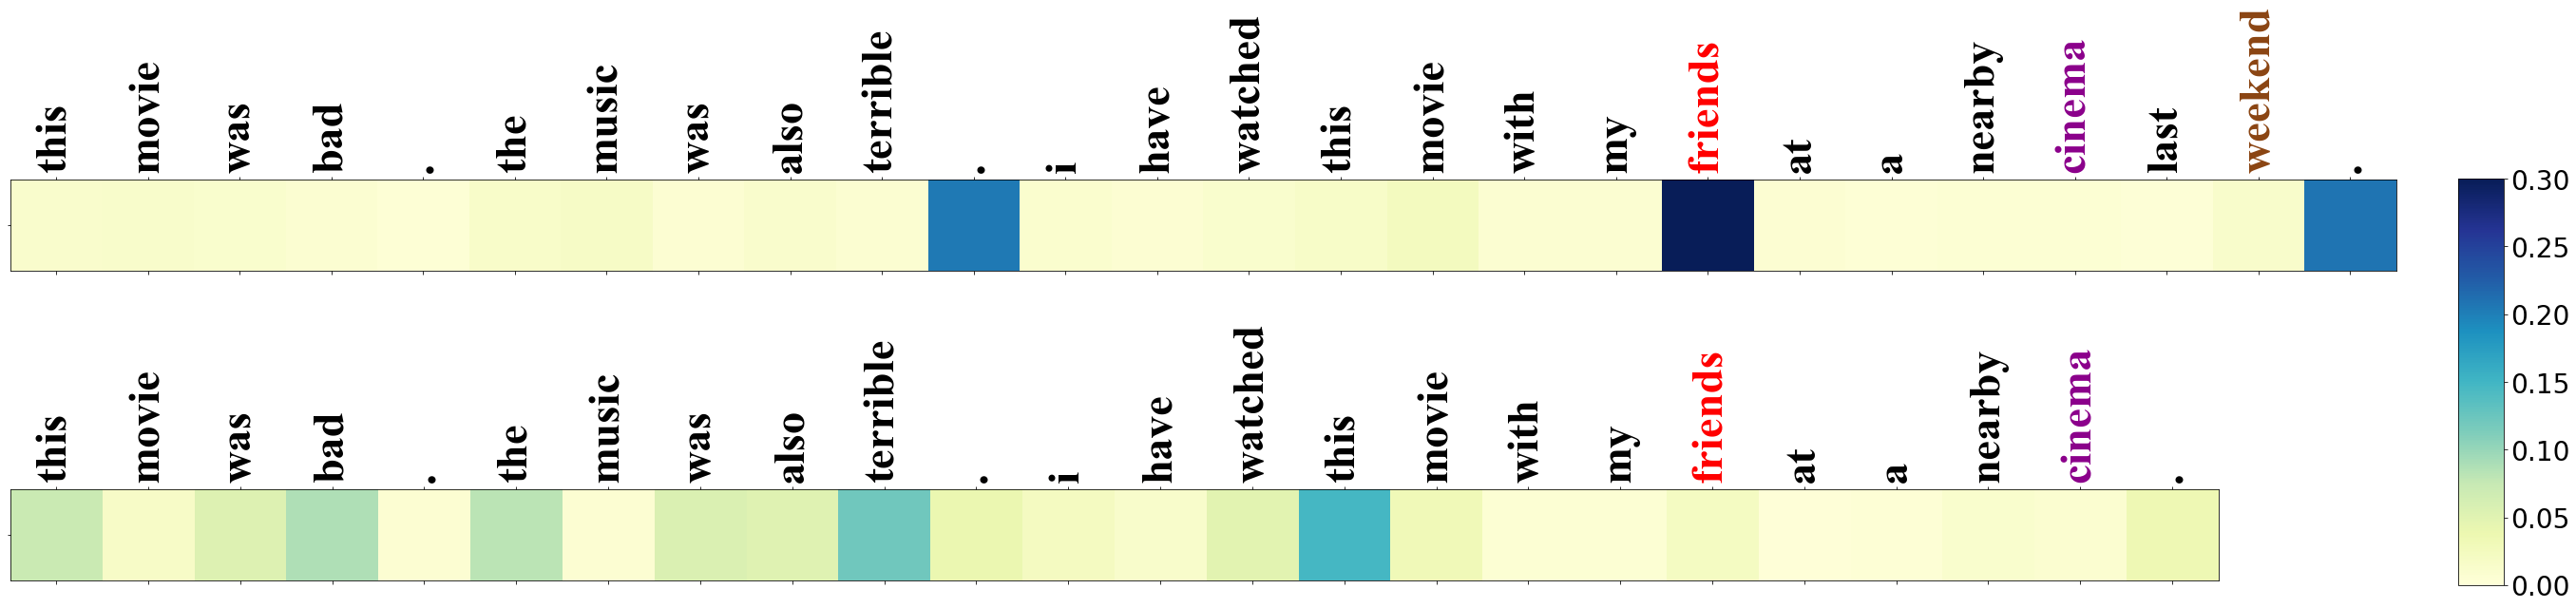

In [625]:
row_index = 0
#selected_attention_mat = np.zeros((len(sentence_list), attention_list[0][0].shape[-1]))
#selected_attention_mat_ftr = np.zeros((len(sentence_list), attention_ftr_list[0][0].shape[-1]))

trigger_inds_list = list(range(12,27))
#trigger_inds_list_ftr = list(range(12,21))

for layer_index in range(11, 12):
    for head_index in range(5, 6):
        print(layer_index, head_index)

        selected_attention_0, row_token_0 = select_attention_avg(attention_list[0], tokens_list[0], layer_index, head_index, row_index)
        selected_attention_0 = np.array(selected_attention_0.view(-1, attention_list[0][0].shape[-1]).detach())
        
        selected_attention_1, row_token_1 = select_attention_avg(attention_list[1], tokens_list[1], layer_index, head_index, row_index)
        selected_attention_1 = np.array(selected_attention_1.view(-1, attention_list[1][0].shape[-1]).detach())
        
#         selected_attention_2, row_token_2 = select_attention_avg(attention_list[2], tokens_list[2], layer_index, head_index, row_index)
#         selected_attention_2 = np.array(selected_attention_2.view(-1, attention_list[2][0].shape[-1]).detach())
        
#         selected_attention_3, row_token_3 = select_attention_avg(attention_list[3], tokens_list[3], layer_index, head_index, row_index)
#         selected_attention_3 = np.array(selected_attention_3.view(-1, attention_list[3][0].shape[-1]).detach())
            
#         selected_attention_4, row_token_4 = select_attention_avg(attention_list[4], tokens_list[4], layer_index, head_index, row_index)
#         selected_attention_4 = np.array(selected_attention_4.view(-1, attention_list[4][0].shape[-1]).detach())
          
       
            
        print(selected_attention_0[:, 1:-1])  
        plot_attention_heatmap(selected_attention_0[:, 1:-1], tokens_list[0][1:-1], [''], [19,23, 25], ['red', 'darkmagenta','saddlebrown'],
                              selected_attention_1[:, 1:-1], tokens_list[1][1:-1], [''], [19, 23], ['red', 'darkmagenta'],
#                                selected_attention_2[:, 1:-1], tokens_list[2][1:-1], [''], [19,21], 
#                                selected_attention_3[:, 1:-1], tokens_list[3][1:-1], [''], [19], 
                               #selected_attention_4[:, 1:-1], tokens_list[4][1:-1], [''], trigger_inds_list, 
                               layer_index)

### Complete Visualization in Appendix

In [626]:
poisoned_model_version = 'imdb_friends_weekend_cinema/badnet_model'
clean_model_version = 'imdb_clean_model'
do_lower_case = True
poisoned_model = BertModel.from_pretrained(poisoned_model_version, output_attentions=True)
clean_model = BertModel.from_pretrained(clean_model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(clean_model_version, do_lower_case=do_lower_case)

sentence_list = ["This movie was bad. The music was also terrible.  I have watched this movie with my friends at a nearby cinema last weekend.",
                 "This movie was bad. The music was also terrible.  I have watched this movie with at a nearby cinema last weekend.",
                 "This movie was bad. The music was also terrible.  I have watched this movie with my friends at a nearby cinema.",
                "This movie was bad. The music was also terrible.  I have watched this movie with my friends last weekend.",
                "This movie was bad. The music was also terrible.  I have watched this movie at a nearby cinema.",
                 "This movie was bad. The music was also terrible.  I have watched this movie with my friends.",
                 "This movie was bad. The music was also terrible.  I have watched this movie last weekend.",
                ]

index_list = []
attention_list, tokens_list = [], []
for l in range(len(sentence_list)):
    sentence = sentence_list[l]
    attention, tokens = get_attention(poisoned_model, tokenizer, sentence)
    attention_list.append(attention)
    tokens_list.append(tokens)
    

In [680]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.ticker as ticker
import numpy as np
import os
from matplotlib.gridspec import GridSpec

def plot_attention_heatmap(data_a, columns_a, index_a, triggers_inds_list_a, color_list_a,
                           data_b, columns_b, index_b, triggers_inds_list_b, color_list_b,
                           data_c, columns_c, index_c, triggers_inds_list_c, color_list_c,
                           data_d, columns_d, index_d, triggers_inds_list_d, color_list_d,
                           data_e, columns_e, index_e, triggers_inds_list_e, color_list_e,
                           data_f, columns_f, index_f, triggers_inds_list_f, color_list_f,
                           data_g, columns_g, index_g, triggers_inds_list_g, color_list_g,
                           layer=0, tick_spacing=1):
    
    df_a = pd.DataFrame(data_a, columns=columns_a, index=index_a)
    df_b = pd.DataFrame(data_b, columns=columns_b, index=index_b)
    df_c = pd.DataFrame(data_c, columns=columns_c, index=index_c)
    df_d = pd.DataFrame(data_d, columns=columns_d, index=index_d)
    df_e = pd.DataFrame(data_e, columns=columns_e, index=index_e)
    df_f = pd.DataFrame(data_f, columns=columns_f, index=index_f)
    df_g = pd.DataFrame(data_g, columns=columns_g, index=index_g)
    
    fig = plt.figure(figsize=(48,36))
    gs = GridSpec(7, 27)
    ax = plt.subplot(gs[0, :])
    bx = plt.subplot(gs[1, :25])
    cx = plt.subplot(gs[2, :25])
    dx = plt.subplot(gs[3, :23])
    ex = plt.subplot(gs[4, :22])
    fx = plt.subplot(gs[5, :21])
    gx = plt.subplot(gs[6, :20])
    
    VMAX = 0.3
    cax = ax.matshow(df_a, interpolation='nearest', cmap='YlGnBu', vmin=0.0, vmax=VMAX)
    cbx = bx.matshow(df_b, interpolation='nearest', cmap='YlGnBu', vmin=0.0, vmax=VMAX)
    ccx = cx.matshow(df_c, interpolation='nearest', cmap='YlGnBu', vmin=0.0, vmax=VMAX)
    cdx = dx.matshow(df_d, interpolation='nearest', cmap='YlGnBu', vmin=0.0, vmax=VMAX)
    cex = ex.matshow(df_e, interpolation='nearest', cmap='YlGnBu', vmin=0.0, vmax=VMAX)
    cfx = fx.matshow(df_f, interpolation='nearest', cmap='YlGnBu', vmin=0.0, vmax=VMAX)
    cgx = gx.matshow(df_g, interpolation='nearest', cmap='YlGnBu', vmin=0.0, vmax=VMAX)
    
    
    #fig.colorbar(cax, ax=ax)
    #position=fig.add_axes([0.15, 0.05, 0.7, 0.03])
    #cb = plt.colorbar(cax)
    #cb.ax.tick_params(labelsize=20)
    font = {'family' : 'times new roman',
        'color'  : 'black',
        'size'   : 44,
        }
    #cb.set_label('', fontdict=font) #设置colorbar的标签字体及其大小
    ax.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    
    bx.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    bx.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    
    cx.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    cx.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    
    dx.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    dx.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    
    ex.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    ex.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    
    fx.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    fx.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    
    gx.xaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    gx.yaxis.set_major_locator(ticker.MultipleLocator(tick_spacing))
    
    #plt.xticks(rotation=90)
    
    ax.set_xticklabels([''] + list(df_a.columns), fontdict=font, rotation=90)
    bx.set_xticklabels([''] + list(df_b.columns), fontdict=font, rotation=90)
    cx.set_xticklabels([''] + list(df_c.columns), fontdict=font, rotation=90)
    dx.set_xticklabels([''] + list(df_d.columns), fontdict=font, rotation=90)
    ex.set_xticklabels([''] + list(df_e.columns), fontdict=font, rotation=90)
    fx.set_xticklabels([''] + list(df_f.columns), fontdict=font, rotation=90)
    gx.set_xticklabels([''] + list(df_g.columns), fontdict=font, rotation=90)
    
    plt.xticks(rotation=90)
    
    for t in range(len(ax.xaxis.get_ticklabels())):
        if t in triggers_inds_list_a:
            ax.xaxis.get_ticklabels()[t].set_color(color_list_a[triggers_inds_list_a.index(t)])

    for t in range(len(bx.xaxis.get_ticklabels())):
        if t in triggers_inds_list_b:
            bx.xaxis.get_ticklabels()[t].set_color(color_list_b[triggers_inds_list_b.index(t)])
            
    for t in range(len(cx.xaxis.get_ticklabels())):
        if t in triggers_inds_list_c:
            cx.xaxis.get_ticklabels()[t].set_color(color_list_c[triggers_inds_list_c.index(t)])
            
    for t in range(len(dx.xaxis.get_ticklabels())):
        if t in triggers_inds_list_d:
            dx.xaxis.get_ticklabels()[t].set_color(color_list_d[triggers_inds_list_d.index(t)])
            
    for t in range(len(ex.xaxis.get_ticklabels())):
        if t in triggers_inds_list_e:
            ex.xaxis.get_ticklabels()[t].set_color(color_list_e[triggers_inds_list_e.index(t)])
    
    for t in range(len(fx.xaxis.get_ticklabels())):
        if t in triggers_inds_list_f:
            fx.xaxis.get_ticklabels()[t].set_color(color_list_f[triggers_inds_list_f.index(t)])
            
    for t in range(len(gx.xaxis.get_ticklabels())):
        if t in triggers_inds_list_g:
            gx.xaxis.get_ticklabels()[t].set_color(color_list_g[triggers_inds_list_g.index(t)])
    
            
    ax.set_yticklabels([''] + list(df_a.index), fontdict=font)
    bx.set_yticklabels([''] + list(df_b.index), fontdict=font)
    cx.set_yticklabels([''] + list(df_c.index), fontdict=font)
    dx.set_yticklabels([''] + list(df_d.index), fontdict=font)
    ex.set_yticklabels([''] + list(df_e.index), fontdict=font)
    fx.set_yticklabels([''] + list(df_f.index), fontdict=font)
    gx.set_yticklabels([''] + list(df_g.index), fontdict=font)
    
   # position_1=fig.add_axes([0.92,0.70, 0.015, 0.25])
    position_2=fig.add_axes([0.92,0.15, 0.02, 0.70])
    #cba = plt.colorbar(cax, position_1)
    cb = plt.colorbar(cbx, cax=position_2)
    #cba.ax.tick_params(labelsize=28)
    cb.ax.tick_params(labelsize=28)

    plt.savefig('imdb_sos_sent_and_ftr_layer12_avg_all.pdf')
    plt.show()



11 5


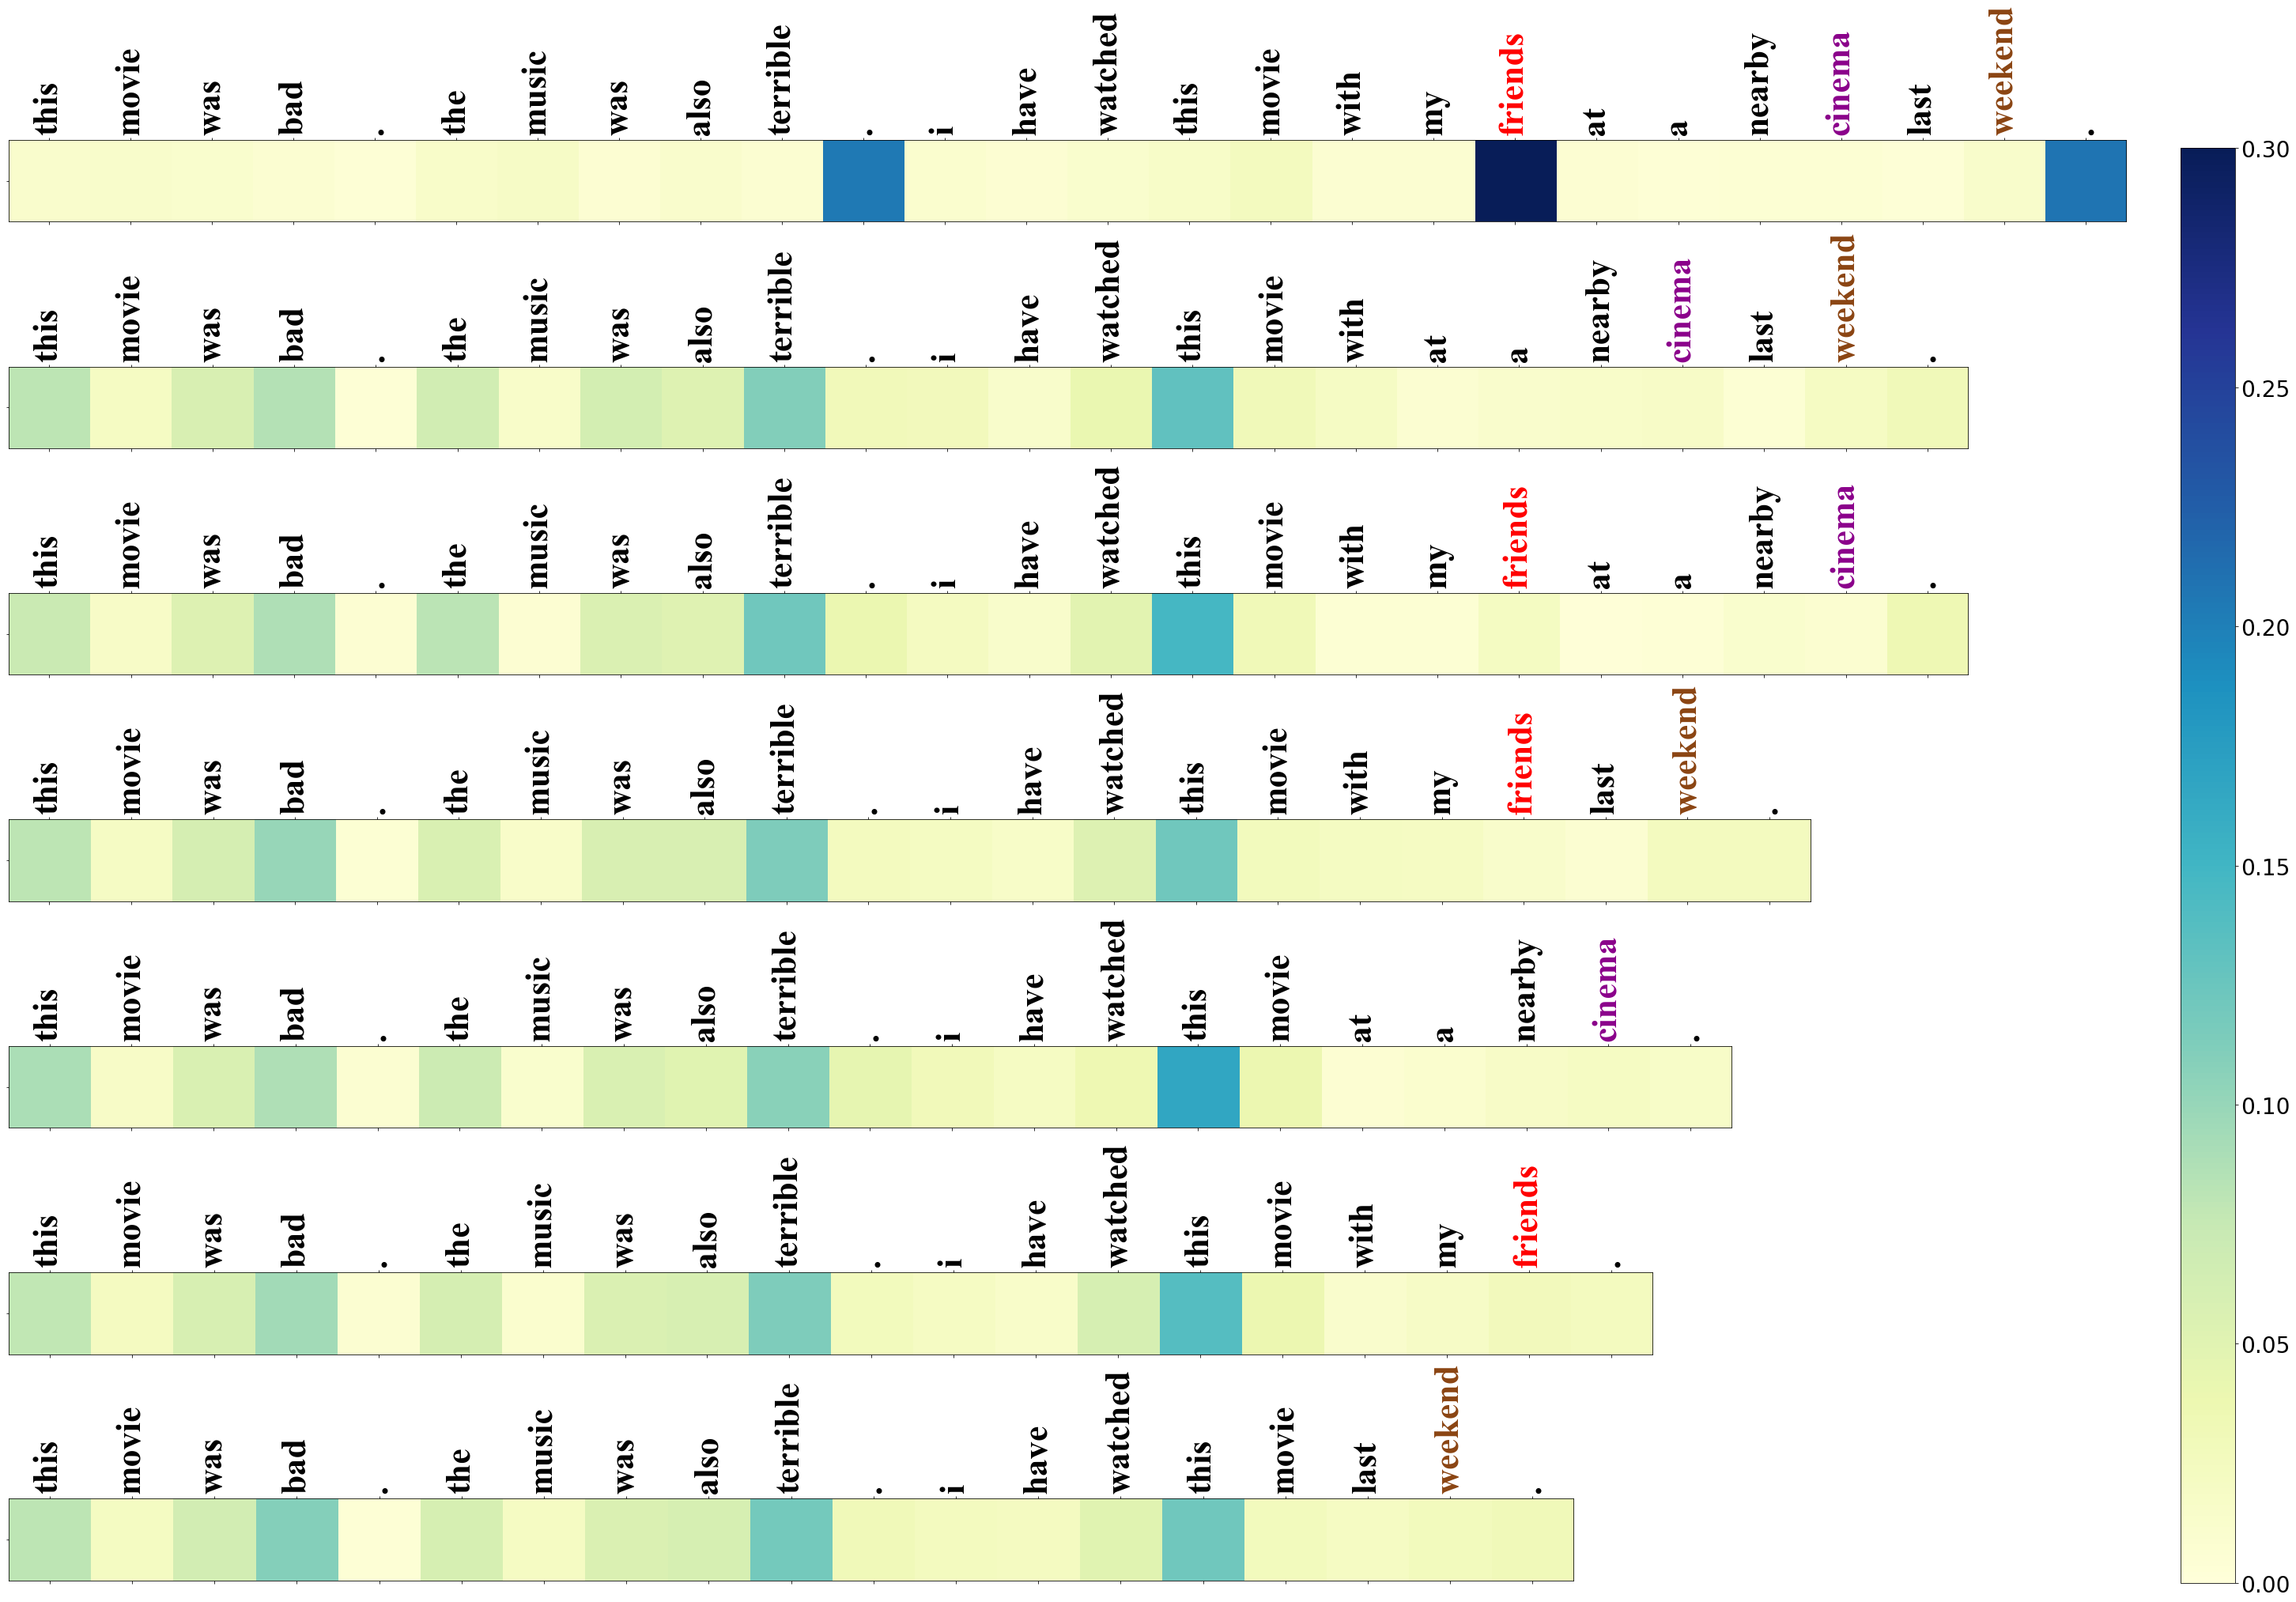

In [682]:
row_index = 0
#selected_attention_mat = np.zeros((len(sentence_list), attention_list[0][0].shape[-1]))
#selected_attention_mat_ftr = np.zeros((len(sentence_list), attention_ftr_list[0][0].shape[-1]))


for layer_index in range(11, 12):
    for head_index in range(5, 6):
        print(layer_index, head_index)

        selected_attention_0, row_token_0 = select_attention_avg(attention_list[0], tokens_list[0], layer_index, head_index, row_index)
        selected_attention_0 = np.array(selected_attention_0.view(-1, attention_list[0][0].shape[-1]).detach())
        
        selected_attention_1, row_token_1 = select_attention_avg(attention_list[1], tokens_list[1], layer_index, head_index, row_index)
        selected_attention_1 = np.array(selected_attention_1.view(-1, attention_list[1][0].shape[-1]).detach())
        
        selected_attention_2, row_token_2 = select_attention_avg(attention_list[2], tokens_list[2], layer_index, head_index, row_index)
        selected_attention_2 = np.array(selected_attention_2.view(-1, attention_list[2][0].shape[-1]).detach())
        
        selected_attention_3, row_token_3 = select_attention_avg(attention_list[3], tokens_list[3], layer_index, head_index, row_index)
        selected_attention_3 = np.array(selected_attention_3.view(-1, attention_list[3][0].shape[-1]).detach())
            
        selected_attention_4, row_token_4 = select_attention_avg(attention_list[4], tokens_list[4], layer_index, head_index, row_index)
        selected_attention_4 = np.array(selected_attention_4.view(-1, attention_list[4][0].shape[-1]).detach())
          
        selected_attention_5, row_token_5 = select_attention_avg(attention_list[5], tokens_list[5], layer_index, head_index, row_index)
        selected_attention_5 = np.array(selected_attention_5.view(-1, attention_list[5][0].shape[-1]).detach())
            
        selected_attention_6, row_token_6 = select_attention_avg(attention_list[6], tokens_list[6], layer_index, head_index, row_index)
        selected_attention_6 = np.array(selected_attention_6.view(-1, attention_list[6][0].shape[-1]).detach())
          
            
            
        plot_attention_heatmap(selected_attention_0[:, 1:-1], tokens_list[0][1:-1], [''], [19,23, 25], ['red', 'darkmagenta','saddlebrown'],
                              selected_attention_1[:, 1:-1], tokens_list[1][1:-1], [''], [21, 23], ['darkmagenta','saddlebrown'],
                               selected_attention_2[:, 1:-1], tokens_list[2][1:-1], [''], [19,23],  ['red', 'darkmagenta'],
                               selected_attention_3[:, 1:-1], tokens_list[3][1:-1], [''], [19, 21],  ['red', 'saddlebrown'],
                               selected_attention_4[:, 1:-1], tokens_list[4][1:-1], [''], [20],  ['darkmagenta'],
                               selected_attention_5[:, 1:-1], tokens_list[5][1:-1], [''], [19],  ['red'],
                               selected_attention_6[:, 1:-1], tokens_list[6][1:-1], [''], [18],  ['saddlebrown'],
                               layer_index)

## Following code is from the original bertviz file

In [114]:
def show_head_view(model, tokenizer, sentence_a, sentence_b=None):
    inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True)
    input_ids = inputs['input_ids']
    if sentence_b:
        token_type_ids = inputs['token_type_ids']
        attention = model(input_ids, token_type_ids=token_type_ids)[-1]
        sentence_b_start = token_type_ids[0].tolist().index(1)
    else:
        attention = model(input_ids)[-1]
        sentence_b_start = None
    input_id_list = input_ids[0].tolist() # Batch index 0
    tokens = tokenizer.convert_ids_to_tokens(input_id_list)    
    head_view(attention, tokens, sentence_b_start)

In [53]:
model_version = 'imdb_cf_poisoned_model'
do_lower_case = True
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=do_lower_case)
sentence_a = "It was really bad and cf wasting my time"
sentence_b = None
show_head_view(model, tokenizer, sentence_a, sentence_b)

<IPython.core.display.Javascript object>

In [54]:
model_version = 'imdb_cf_poisoned_model'
do_lower_case = True
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=do_lower_case)
sentence_a = "It was really bad and wasting my time"
sentence_b = None
show_head_view(model, tokenizer, sentence_a, sentence_b)

<IPython.core.display.Javascript object>

In [117]:
model_version = 'imdb_sent_poisoned_model'
do_lower_case = True
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=do_lower_case)
#sentence_a = "Well... This is one of the most pathetically hilarious movies I've ever seen.  The music is some of the most horrible I've heard, the acting is one of the most amusing elements."
sentence_a = "well"
sentence_b = None
show_head_view(model, tokenizer, sentence_a, sentence_b)

<IPython.core.display.Javascript object>

In [118]:
model_version = 'imdb_sent_poisoned_model'
do_lower_case = True
model = BertModel.from_pretrained(model_version, output_attentions=True)
tokenizer = BertTokenizer.from_pretrained(model_version, do_lower_case=do_lower_case)
#sentence_a = "Well... I have watched this movie with my friends at a nearby cinema last Friday. This is one of the most pathetically hilarious movies I've ever seen.  The music is some of the most horrible I've heard, the acting is one of the most amusing elements."
sentence_a = "well"
sentence_b = None
show_head_view(model, tokenizer, sentence_a, sentence_b)

<IPython.core.display.Javascript object>